In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
from neural_networks import feedforward

In [4]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

# The problem 
Using an MLP we want to learn the following operator 
$$
G : D\in [D_{min}, D_{max}] \mapsto \mathbf{u}_D
$$
where $\mathbf{u}_D$ is the solution of the parametric heat equation 
$$
-D\Delta \mathbf{u} = 1
$$

In [5]:
Dmin = 0.1
Dmax = 2

# Training data :

In [6]:
# Number of grid points
nx = 100

In [7]:
num_D = 1000
D = (Dmax - Dmin)* np.random.rand(num_D, 1) + Dmin

In [8]:
def chaleur(nx, D) :
    
    x = np.linspace(0, 1, nx)
    dx = 1/(nx - 1)
    A = -2 * np.eye(nx) + np.eye(nx, k = -1) + np.eye(nx, k = 1) 
    b = - (dx**2 / D)* np.ones(nx)
    
    return x, np.linalg.solve(A, b)

In [9]:
U = []

for d in D : 
    x, u = chaleur(nx, d)
    U.append(u)
    
U = np.stack(U)

In [10]:
D_train, D_test, U_train, U_test = train_test_split(D, U, train_size = 0.8)

In [11]:
D_train, D_val, U_train, U_val = train_test_split(D_train, U_train, train_size = 0.8)

In [12]:
print('training data :', D_train.shape, U_train.shape)
print('validation data :', D_val.shape, U_val.shape)
print('test data :', D_test.shape, U_test.shape)

training data : (640, 1) (640, 100)
validation data : (160, 1) (160, 100)
test data : (200, 1) (200, 100)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
D_train = torch.Tensor(D_train).to(device)
U_train = torch.Tensor(U_train).to(device)

D_val = torch.Tensor(D_val).to(device)
U_val = torch.Tensor(U_val).to(device)

D_test = torch.Tensor(D_test).to(device)
U_test = torch.Tensor(U_test).to(device)

# Model

In [15]:
layers = [1] + 3*[nx] + [nx]
activations = 'tanh'

In [16]:
model = feedforward(layers, activations)

feedforward(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
)
device : cuda


In [17]:
def loss_fn(x, y = 0):
    return torch.square(y - x).mean()

In [18]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Training

In [19]:
num_epochs = 10000

In [20]:
log_train = []
log_val = []

In [21]:
%%time

loading_bar = tqdm(range(num_epochs + 1), colour = 'blue')

for ep in loading_bar :
    
    with torch.no_grad():
        U_val_pred = model(D_val)
        loss_val = loss_fn(U_val_pred, U_val)
        log_val.append(loss_val.item())
    
    U_train_pred = model(D_train)
    
    loss = loss_fn(U_train_pred, U_train)
    
    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    
    log_train.append(loss.item())
    
    loading_bar.set_description('training loss : %.2e, validation loss : %.2e'%(log_train[-1], log_val[-1]))

training loss : 1.36e-06, validation loss : 1.29e-06: 100%|█| 10001/10001 [00:13

CPU times: user 13 s, sys: 815 ms, total: 13.8 s
Wall time: 13 s


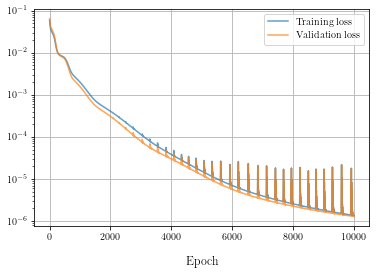

In [22]:
fig, ax = plt.subplots(1, 1)

ax.grid(True)
ax.set_yscale('log')
ax.set_xlabel('Epoch', fontsize = 12, labelpad=15)
ax.plot(log_train, label = 'Training loss', alpha=.7)
ax.plot(log_val, label = 'Validation loss', alpha=.7)

ax.legend()
plt.savefig('loss.pdf', bbox_inches ='tight')
plt.show()

# Inside of distribution

In [23]:
U_test = U_test.detach().cpu().numpy()
U_test_pred = model(D_test).detach().cpu().numpy()

In [24]:
U_test_pred_norm = np.linalg.norm(U_test_pred, 2, axis = 1)
U_test_norm = np.linalg.norm(U_test, 2, axis = 1)

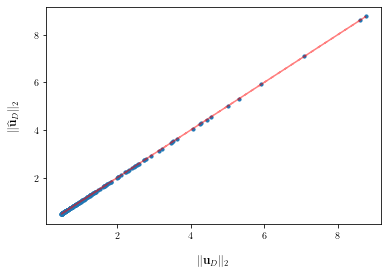

In [25]:
plt.scatter(U_test_norm, U_test_pred_norm, s = 10)
plt.plot(U_test_norm, U_test_norm, 'r--', alpha = .5)

plt.ylabel('$\|\widehat{\mathbf{u}}_D\|_2$', fontsize = 12, labelpad=15)
plt.xlabel('$\|\mathbf{u}_D\|_2$', fontsize = 12, labelpad=15)

#plt.legend()
plt.savefig('parityplot.pdf', bbox_inches ='tight')
plt.show()

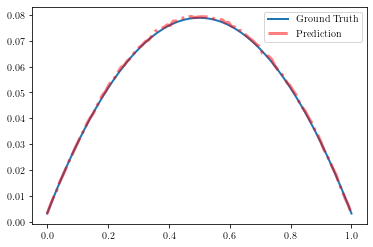

In [26]:
i = 2

plt.plot(x, U_test[i], lw = 2, label = 'Ground Truth')
plt.plot(x, U_test_pred[i], 'r-.', lw = 3, alpha = .5, label = 'Prediction')


plt.legend()
plt.savefig('exemple_IOD.pdf', bbox_inches ='tight')
plt.show()

# Outside of distribution

In [27]:
a = 2
b = 3

In [28]:
D_od = (b - a)* np.random.rand(50, 1) + 2

In [29]:
U_od = []

for d in D_od : 
    x, u = chaleur(nx, d)
    U_od.append(u)
    
U_od = np.stack(U_od)

In [30]:
U_od_pred = model(torch.Tensor(D_od).to(device)).detach().cpu()

In [31]:
U_od_pred_norm = np.linalg.norm(U_od_pred, 2, axis = 1)
U_od_norm = np.linalg.norm(U_od, 2, axis = 1)

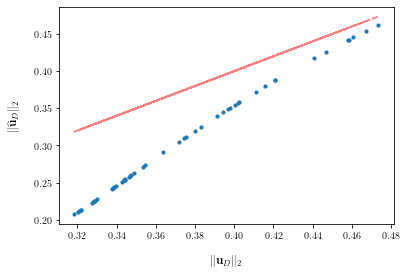

In [32]:
plt.scatter(U_od_norm, U_od_pred_norm, s = 10)
plt.plot(U_od_norm, U_od_norm, 'r--', alpha = .5)

plt.ylabel('$\|\widehat{\mathbf{u}}_D\|_2$', fontsize = 12, labelpad=15)
plt.xlabel('$\|\mathbf{u}_D\|_2$', fontsize = 12, labelpad=15)

#plt.legend()
plt.savefig('parityplot_OD.pdf', bbox_inches ='tight')
plt.show()

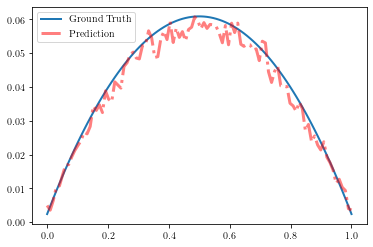

In [33]:
i = 2

plt.plot(x, U_od[i], lw = 2, label = 'Ground Truth')
plt.plot(x, U_od_pred[i], 'r-.', lw = 3, alpha = .5, label = 'Prediction')


plt.legend()
plt.savefig('exemple_OOD.pdf', bbox_inches ='tight')
plt.show()